In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import random


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

# set text size for plots to be larger
plt.rcParams.update({"font.size": 16})

import glob
import os
import tqdm
import plot_fuctions as pf
from plot_fuctions import load_and_process_file, get_revo_count, get_combined_count, set_paths


In [5]:
%matplotlib inline

In [ ]:
# change current working directory to the folder where the data is stored
cwd = os.chdir("/home/joe/ttop/cascade/")
data_path = os.getcwd() + "/data/midway_294444"
model_path = os.getcwd() + "/data/midway_full_run/model/"
image_path = os.getcwd() + "/model_analysis/analysis_images/midway_294444/"
data_directory = pf.set_paths(data_path, image_path)

all_files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.parquet')]
all_dataframes = [load_and_process_file(file_path) for file_path in all_files]
df = pd.concat(all_dataframes, ignore_index=True)
print(df.head())

In [ ]:
unique_model_count = df["Model"].nunique()
print(f"There are {unique_model_count} unique values in the 'model' column.")
get_revo_count(df)
df = get_combined_count(df)

In [6]:
# print current working directory
print("Current working directory: {0}".format(os.getcwd()))
# change current working directory
os.chdir("/home/joe/ttop/cascade/")

Current working directory: /home/joe/ttop/cascade/model_analysis


In [7]:
df = pd.read_parquet("data/midway_294444.parquet")
image_path = os.getcwd() + "/model_analysis/analysis_images/2023-04-26/"

In [8]:
# Create a dictionary to map Model values to unique numbers
model_number_mapping = {model: i for i, model in enumerate(df['Model'].unique())}

# Create a new column 'Model Number' by applying the mapping to the 'Model' column
df['Model Number'] = df['Model'].map(model_number_mapping)

In [9]:
# Get unique models from the DataFrame
unique_models = df['Model Number'].unique()

# Iterate over unique models and update Revolution values
for model in unique_models:
    if df[df['Model Number'] == model]['Revolution'].any():
        df.loc[df['Model Number'] == model, 'Revolution'] = True

In [14]:
# Filter the data based on the given conditions
filtered_df = df.loc[
    (df['Seed'] == df['Seed'].shift()) &
    (df['Security Density'] == df['Security Density'].shift()) &
    (df['Private Preference'] == df['Private Preference'].shift())
]

# Group the filtered DataFrame by Seed, Security Density, and Private Preference
grouped_df = filtered_df.groupby(['Seed', 'Security Density', 'Private Preference'])

# Initialize an empty list to store model pairs
model_pairs = []

# Iterate through the grouped DataFrame
for _, group in grouped_df:
    revolution_true_models = group[(group['Revolution'] == True) & (group['Epsilon'] == 0.2)]['Model'].unique()
    revolution_false_models = group[(group['Revolution'] == False) & (group['Epsilon'] == 1.0)]['Model'].unique()
    
    # Check if there is exactly one model with Revolution == True and one model with Revolution == False
    if len(revolution_true_models) == 1 and len(revolution_false_models) == 1:
        model_pairs.append((revolution_true_models[0], revolution_false_models[0]))

# Print the list of model pairs
print("Model Pairs:")
for pair in model_pairs:
    print(pair)
print(len(model_pairs))


Model Pairs:
('Seed 344000 SD0.02 PP -0.8 EP 0.2 Th 2.94444', 'Seed 344000 SD0.02 PP -0.8 EP 1 Th 2.94444')
('Seed 344000 SD0.02 PP -0.5 EP 0.2 Th 2.94444', 'Seed 344000 SD0.02 PP -0.5 EP 1 Th 2.94444')
('Seed 344000 SD0.02 PP -0.2 EP 0.2 Th 2.94444', 'Seed 344000 SD0.02 PP -0.2 EP 1 Th 2.94444')
('Seed 344002 SD0.02 PP -0.5 EP 0.2 Th 2.94444', 'Seed 344002 SD0.02 PP -0.5 EP 1 Th 2.94444')
('Seed 344003 SD0.02 PP -1 EP 0.2 Th 2.94444', 'Seed 344003 SD0.02 PP -1 EP 1 Th 2.94444')
('Seed 344004 SD0.02 PP -0.8 EP 0.2 Th 2.94444', 'Seed 344004 SD0.02 PP -0.8 EP 1 Th 2.94444')
('Seed 344005 SD0.02 PP -0.8 EP 0.2 Th 2.94444', 'Seed 344005 SD0.02 PP -0.8 EP 1 Th 2.94444')
('Seed 344006 SD0.02 PP -1 EP 0.2 Th 2.94444', 'Seed 344006 SD0.02 PP -1 EP 1 Th 2.94444')
('Seed 344007 SD0.02 PP -1 EP 0.2 Th 2.94444', 'Seed 344007 SD0.02 PP -1 EP 1 Th 2.94444')
('Seed 344007 SD0.02 PP -0.8 EP 0.2 Th 2.94444', 'Seed 344007 SD0.02 PP -0.8 EP 1 Th 2.94444')
('Seed 344008 SD0.02 PP -0.5 EP 0.2 Th 2.94444', 

<Figure size 1000x600 with 0 Axes>

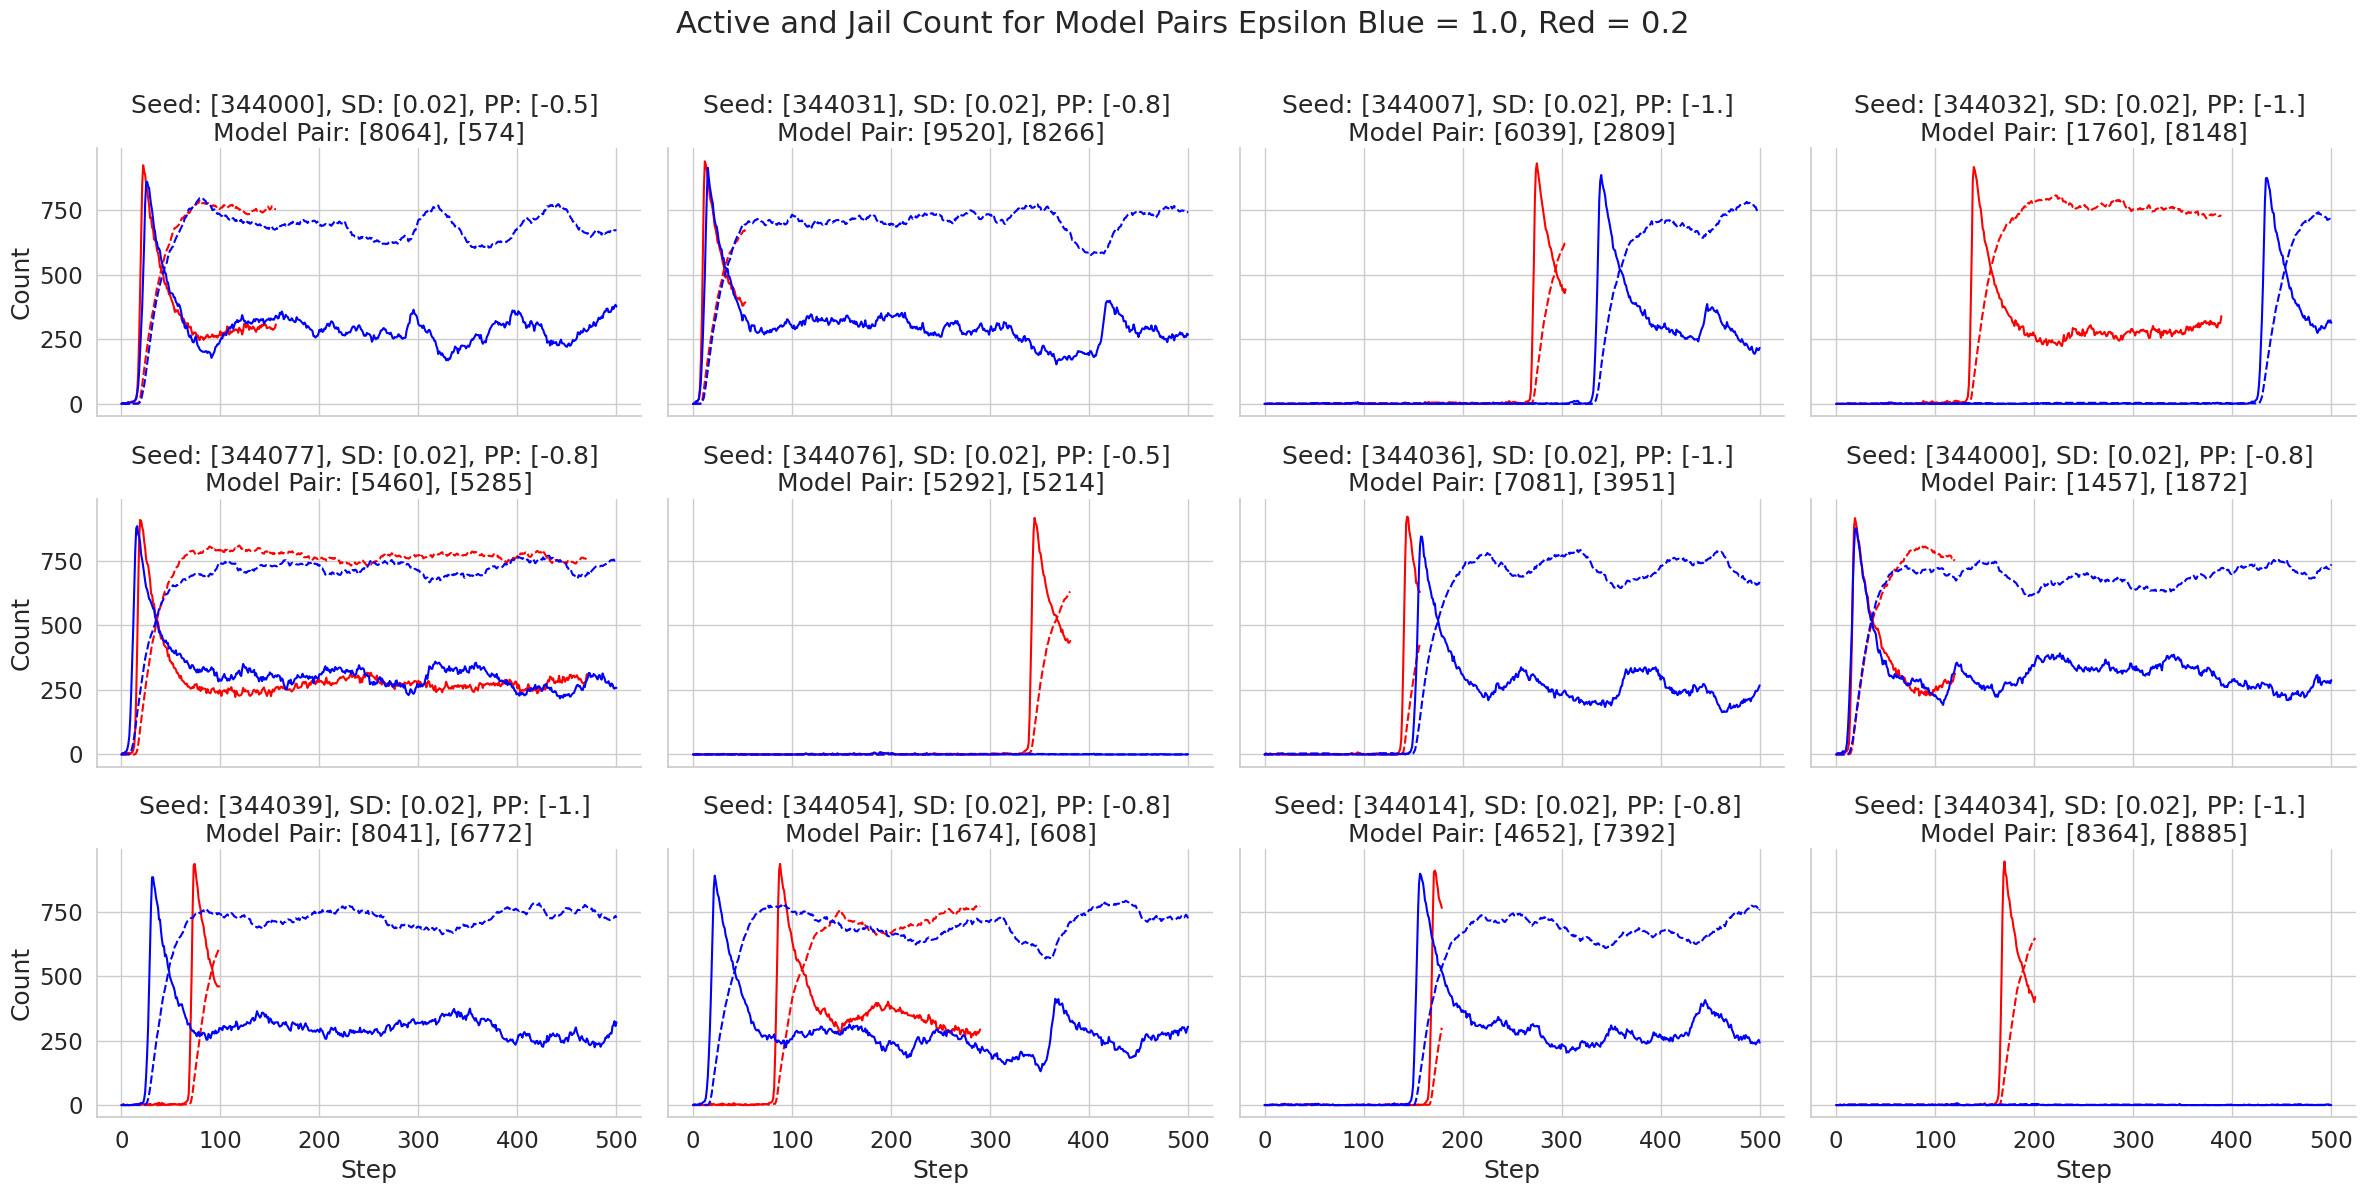

In [36]:
# Filter the DataFrame to only include rows with the selected model pairs
selected_models = [model for pair in model_pairs for model in pair]
filtered_df = df[df['Model'].isin(selected_models)]

# Choose a random 10 pairs instead of all pairs
random_pairs = random.sample(model_pairs, 12)

# Filter the DataFrame to only include rows with the selected models
filtered_df = df[df['Model'].isin([model for pair in random_pairs for model in pair])]

# Melt the DataFrame to have separate columns for Active and Jail Count
melted_df = pd.melt(
    filtered_df,
    id_vars=['Model', 'Model Number', 'Epsilon', 'Step'],
    value_vars=['Active Count', 'Jail Count'],
    var_name='Count_Type',
    value_name='Count'
)

# Combine Model and Count_Type columns into a new column
melted_df['Model_Count_Type'] = melted_df['Model'] + ' - ' + melted_df['Count_Type']

# Create a new column for pair number
model_to_pair = {model: i + 1 for i, pair in enumerate(random_pairs) for model in pair}
melted_df['Pair'] = melted_df['Model'].map(model_to_pair)

# Create a color map based on the Epsilon values
color_map = {0.1: 'red', 0.2: 'red', 1.0: 'blue'}

sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Create a Figure object
fig = plt.figure(figsize=(10, 6))

# Create the FacetGrid with the 'Pair' column
g = sns.FacetGrid(
    data=melted_df,
    col='Pair',
    col_wrap=4,
    height=4,
    aspect=1.5,
    sharex=True,
    sharey=True,
    margin_titles=True
)

# Set the overall title for the FacetGrid
g.fig.suptitle("Active and Jail Count for Model Pairs Epsilon Blue = 1.0, Red = 0.2", y=1.00, fontsize=22)

# Plot the Active and Jail Count
g.map_dataframe(sns.lineplot, x='Step', y='Count', hue='Epsilon', style='Count_Type', palette=color_map, legend=False)

# Customize the titles for each graph in the facet
g.set_titles(template="{col_name}")

# Change the title to display the model number pair
for ax, pair in zip(g.axes.flat, random_pairs):
    ax.set_title(f"Seed: {df[df['Model'] == pair[0]]['Seed'].unique()}, SD: {df[df['Model'] == pair[0]]['Security Density'].unique()}, PP: {df[df['Model'] == pair[0]]['Private Preference'].unique()} \nModel Pair: {df[df['Model'] == pair[0]]['Model Number'].unique()}, {df[df['Model'] == pair[1]]['Model Number'].unique()}")

# Save the figure
plt.savefig(image_path + "facet_graph.png", dpi=300, bbox_inches='tight')

# Adjust the layout to accommodate the overall title
g.fig.tight_layout()

# Show the plot
plt.show()


In [27]:
def check_models(df, model1, model2):
    # Extract Epsilon, Model Seed, Security Density and Private Preference values for each model
    epsilon1 = df[df['Model Number'] == model1]['Epsilon'].unique()[0]
    epsilon2 = df[df['Model Number'] == model2]['Epsilon'].unique()[0]
    model_seed1 = df[df['Model Number'] == model1]['Seed'].unique()[0]
    model_seed2 = df[df['Model Number'] == model2]['Seed'].unique()[0]
    security_density1 = df[df['Model Number'] == model1]['Security Density'].unique()[0]
    security_density2 = df[df['Model Number'] == model2]['Security Density'].unique()[0]
    private_preference1 = df[df['Model Number'] == model1]['Private Preference'].unique()[0]
    private_preference2 = df[df['Model Number'] == model2]['Private Preference'].unique()[0]

    print(f"Model 1: {df[df['Model Number'] == model1]['Model'].unique()}, {model1}")
    print(f"Model 1: Revolutions: {df[df['Model Number'] == model1]['Revolution'].unique()}")
    print(f"Model 1: {df[df['Model Number'] == model2]['Model'].unique()}, {model2}")
    print(f"Model 2: Revolutions: {df[df['Model Number'] == model2]['Revolution'].unique()}")

    # Model 1
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Step', y='Active Count', data=df[df['Model Number'] == model1], label=f'Active Count (Epsilon {epsilon1})', color='red')
    sns.lineplot(x='Step', y='Jail Count', data=df[df['Model Number'] == model1], label=f'Jail Count (Epsilon {epsilon1})', linestyle='--', color='red')
    sns.lineplot(x='Step', y='Active Count', data=df[df['Model Number'] == model2], label=f'Active Count (Epsilon {epsilon2})', color='blue')
    sns.lineplot(x='Step', y='Jail Count', data=df[df['Model Number'] == model2], label=f'Jail Count (Epsilon {epsilon2})', linestyle='--', color='blue')
    
    # Set the title with Model Seed, Security Density, and Private Preference
    plt.title(f'Models Seed {model_seed1}, Sec. Density {security_density1}, Priv. Pref. {private_preference1}')


    plt.ylim(0, 1120)
    plt.xlim(0, 500)
    plt.legend()

    # Save the figure
    plt.savefig(image_path + f"model_{model1}_{model2}.png", dpi=300, bbox_inches='tight')
    
    plt.show()


Model 1: ['Seed 344031 SD0.02 PP -0.5 EP 0.2 Th 2.94444'], 253
Model 1: Revolutions: [ True]
Model 1: ['Seed 344031 SD0.02 PP -0.5 EP 1 Th 2.94444'], 3648
Model 2: Revolutions: [False]


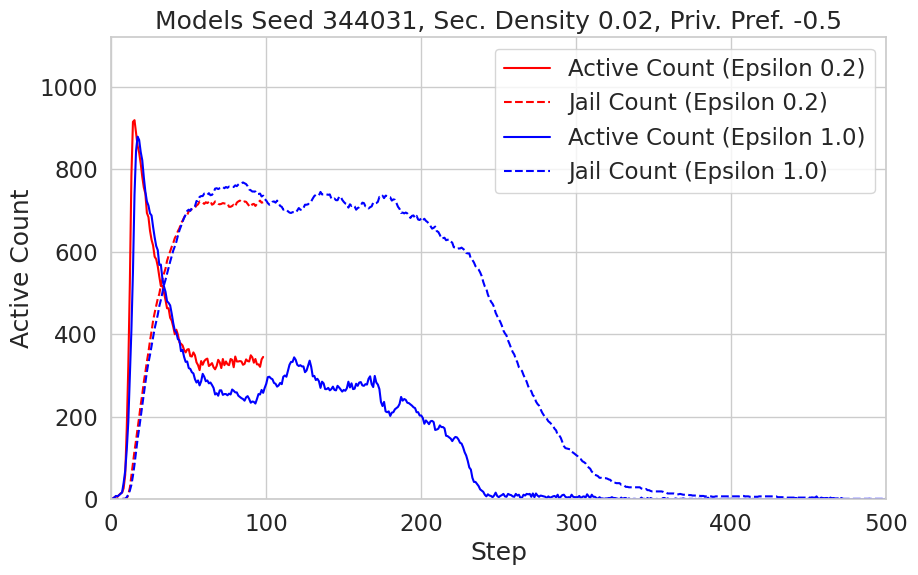

In [28]:
check_models(df, 253, 3648)

Model 1: ['Seed 344089 SD0.01 PP -1 EP 0.2 Th 2.94444'], 1189
Model 1: Revolutions: [ True]
Model 1: ['Seed 344089 SD0.01 PP -1 EP 0.1 Th 2.94444'], 4507
Model 2: Revolutions: [ True]


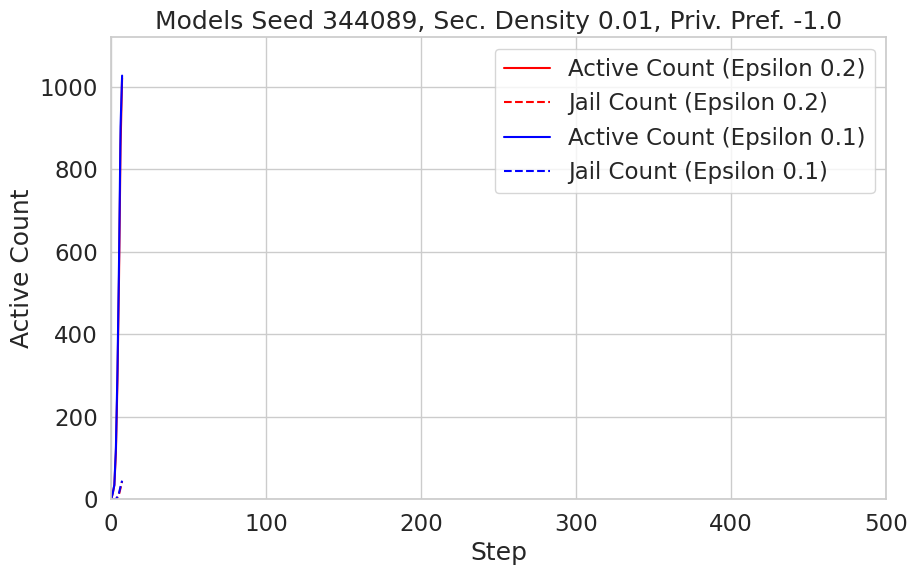

In [77]:
check_models(df, 1189, 4507)

In [37]:
ag_df_1 = pd.read_parquet("data/2023-04-26/agent/agent_seed_344031_pp_-0.5_sd0.02_ep_0.2_th2.94444.parquet")
ag_df_2 = pd.read_parquet("data/2023-04-26/agent/agent_seed_344031_pp_-0.5_sd0.02_ep_1_th2.94444.parquet")

In [56]:
ag_df_1.head()

pos condition   opinion  activation  private_preference  \
Step AgentID                                                                 
0    1          [0, 3]   Support -0.351728    0.412963            0.358439   
     2        [38, 27]   Support  0.524957    0.628306           -0.518933   
     3          [7, 7]   Support  1.157801    0.760933           -1.151349   
     4        [15, 37]   Support -1.074958    0.254461            1.081452   
     5         [21, 7]   Support  0.387175    0.595602           -0.380964   

               epsilon  oppose_threshold  active_threshold  jail_sentence  \
Step AgentID                                                                
0    1       -0.079540          2.941502          3.059267            0.0   
     2       -0.046827          2.864739          2.905786            0.0   
     3       -0.311303          2.964809          2.997987            0.0   
     4        0.104377          2.736812          3.027027            0.0   
     5       -0.081585          2.804335          2.871532            0.0   

              actives_in_vision  ... arrest_prob active_level  oppose_level  \
Step AgentID                     ...                                          
0    1                      1.0  ...    0.999854    -0.967901     -0.964050   
     2                      1.0  ...    0.999987    -0.915340     -0.912105   
     3                      1.0  ...    0.999582    -0.862552     -0.858582   
     4                      1.0  ...    0.999994    -0.983724     -0.978364   
     5                      1.0  ...    0.999998    -0.923036     -0.918125   

              flip  ever_flipped  model_seed  model_security_density  \
Step AgentID                                                           
0    1        None         False      344031                    0.02   
     2        None         False      344031                    0.02   
     3        None         False      344031                    0.02   
     4        None         False      344031                    0.02   
     5        None         False      344031                    0.02   

             model_private_preference model_epsilon  model_threshold  
Step AgentID                                                          
0    1                           -0.5           0.2          2.94444  
     2                           -0.5           0.2          2.94444  
     3                           -0.5           0.2          2.94444  
     4                           -0.5           0.2          2.94444  
     5                           -0.5           0.2          2.94444  

[5 rows x 24 columns]

In [59]:
def plot_kde_thre(ag_df):
    # Set the style for the plot
    sns.set(style='whitegrid')

    # Create the KDE plot for oppose_threshold and active_threshold
    plt.figure(figsize=(10, 6))
    sns.kdeplot(ag_df['oppose_threshold'], color='blue', fill=True, label='Oppose Threshold')
    sns.kdeplot(ag_df['active_threshold'], color='red', fill=True, label='Active Threshold')


    # Customize the plot
    plt.title(f'KDE Plot for Oppose and Active Thresholds for Epsilon {ag_df["model_epsilon"].unique()}')
    plt.xlabel('Threshold')
    plt.ylabel('Density')
    plt.legend()

    # Save the figure
    plt.savefig(image_path + f"kde_plot_thresh_{ag_df['model_epsilon'].unique()}.png", dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

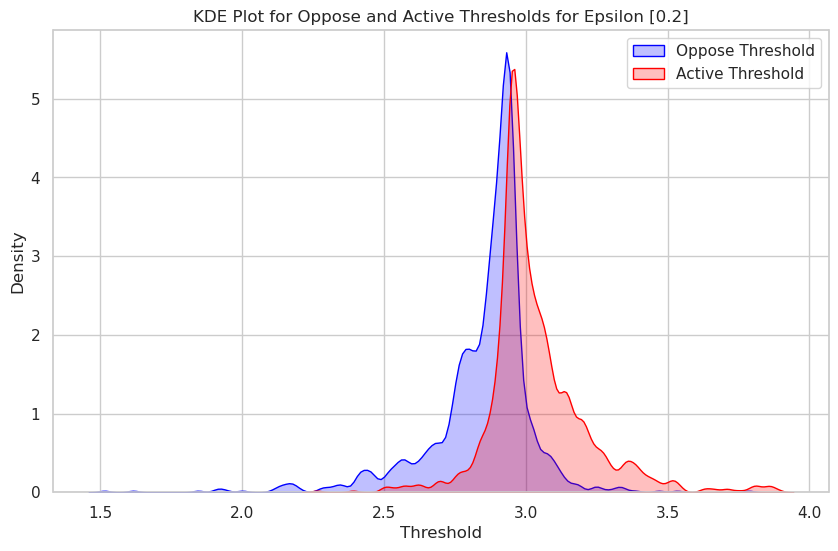

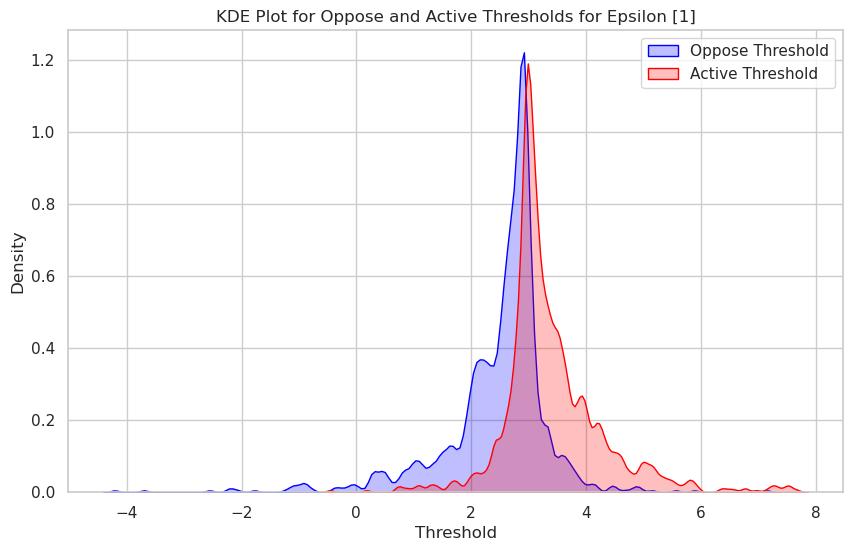

In [60]:
plot_kde_thre(ag_df_1)
plot_kde_thre(ag_df_2)

In [42]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

def plot_kde_thre_double(ag_df, ag_df_2):
    # Set the style for the plot
    sns.set(style='whitegrid')

    # Create a custom color palette
    cmr_colors = sns.color_palette("CMRmap_r", 10)
    
    # Create the KDE plot for oppose_threshold and active_threshold
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.kdeplot(ag_df['oppose_threshold'], color=cmr_colors[2], fill=True, label='Oppose Threshold Epsilon 0.2', ax=ax)
    sns.kdeplot(ag_df['active_threshold'], color=cmr_colors[4], fill=True, label='Active Threshold Epsilon 0.2', ax=ax)
    sns.kdeplot(ag_df_2['oppose_threshold'], color=cmr_colors[7], fill=True, label='Oppose Threshold Epsilon 1.0', ax=ax)
    sns.kdeplot(ag_df_2['active_threshold'], color=cmr_colors[9], fill=True, label='Active Threshold Epsilon 1.0', ax=ax)

    # Customize the plot
    plt.title('KDE Plot for Oppose and Active Thresholds for Two Epsilon Distributions of Seed 344031')
    plt.xlabel('Threshold')
    plt.ylabel('Density')

    # Create the inset
    axins = inset_axes(ax, width="40%", height="60%", loc="upper left", borderpad=5)
    axins.set_xlabel('Threshold')
    sns.kdeplot(ag_df['oppose_threshold'], color=cmr_colors[2], fill=True, ax=axins)
    sns.kdeplot(ag_df['active_threshold'], color=cmr_colors[4], fill=True, ax=axins)
    sns.kdeplot(ag_df_2['oppose_threshold'], color=cmr_colors[7], fill=True, ax=axins)
    sns.kdeplot(ag_df_2['active_threshold'], color=cmr_colors[9], fill=True, ax=axins)

    # Set inset axis limits
    axins.set_xlim(2, 4)
    axins.set_ylim(0, 1.5)

    # Move the legend outside of the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.savefig(image_path + "Oppose Active Thresh 2 ep 253 3648.png", dpi=300, bbox_inches="tight")

    # Display the plot
    plt.show()

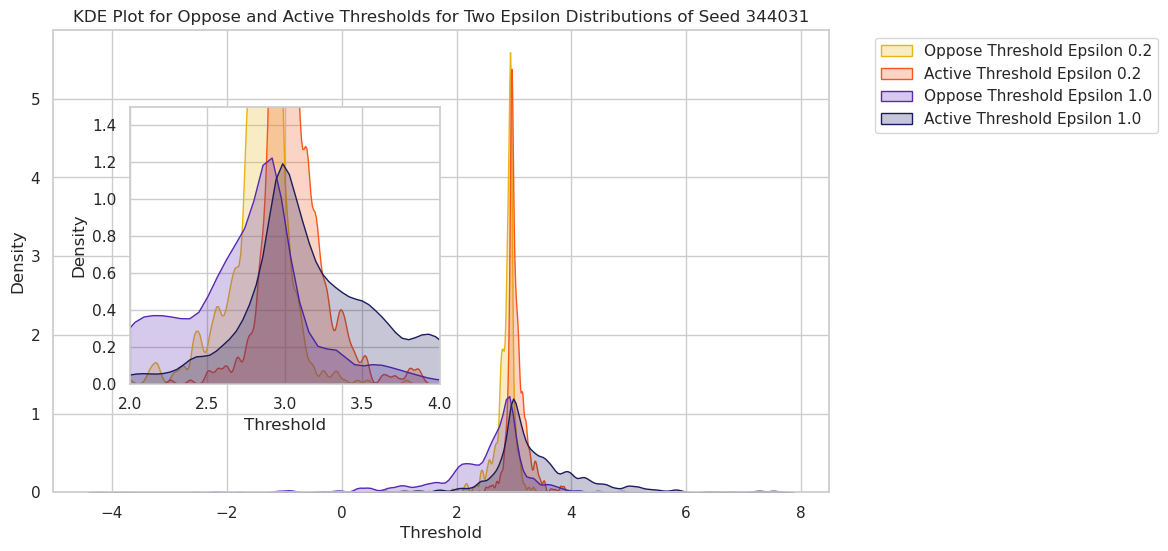

In [43]:
plot_kde_thre_double(ag_df_1, ag_df_2)

In [ ]:
def plot_kde_act(ag_df):
    # Set the style for the plot
    sns.set(style='whitegrid')

    # Create the KDE plot for oppose_threshold and active_threshold
    plt.figure(figsize=(10, 6))
    sns.kdeplot(ag_df['oppose_level'], color='blue', fill=True, label='Oppose Threshold')
    sns.kdeplot(ag_df['active_level'], color='red', fill=True, label='Active Threshold')

    # Customize the plot
    plt.title('KDE Plot for Oppose and Active Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Density')
    plt.legend()

    # Save the figure
    plt.savefig(image_path + "kde_plot_act.png", dpi=300, bbox_inches='tight')
    # Display the plot
    plt.show()

# Replace "ag_df" with the actual DataFrame variable name

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

def plot_kde_act_animated(ag_df, steps):
    # Set the style for the plot
    sns.set(style='whitegrid')

    # Create a function to update the plot at each time step
    def update(t):
        plt.clf()
        if t in ag_df.index:
            current_df = ag_df.loc[t]
        else:
            return
        sns.kdeplot(current_df['oppose_level'], color='blue', fill=True, label='Oppose Threshold')
        sns.kdeplot(current_df['active_level'], color='red', fill=True, label='Active Threshold')
        plt.title(f'KDE Plot for Oppose and Active Thresholds at Time Step {t}')
        plt.xlabel('Threshold')
        plt.ylabel('Density')
        plt.legend()

    # Create the animated plot
    fig = plt.figure(figsize=(10, 6))
    ani = FuncAnimation(fig, update, frames=range(len(ag_df)), interval=200)

    # Save the animation as a GIF file
    ani.save("kde_animation.gif", writer=PillowWriter(fps=15))

    # Display the plot
    plt.show()

In [105]:
plot_kde_act_animated(ag_df_1, 500)

<IPython.core.display.Javascript object>

: 

: 

ValueError: Could not interpret value `Epsilon` for parameter `x`

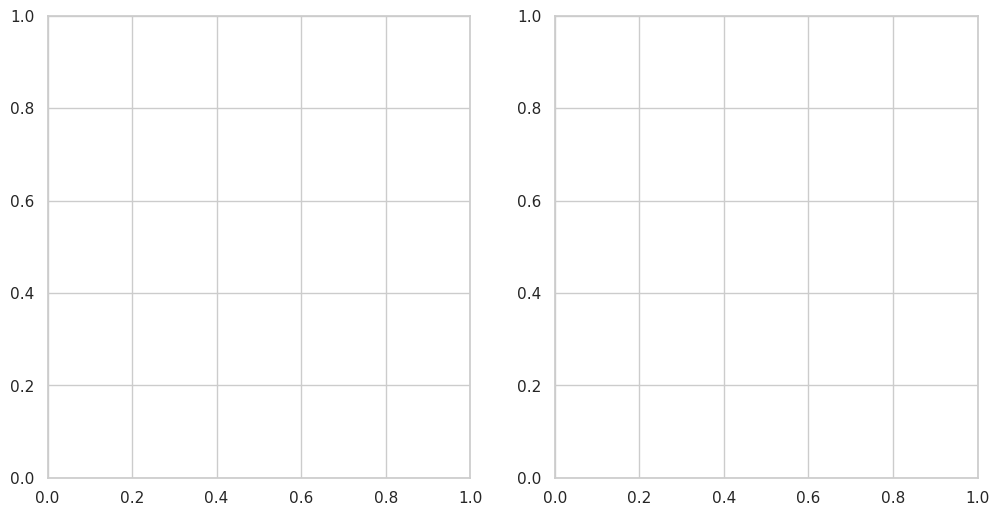

In [44]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot histogram with kde overlay for Epsilon column in df1
sns.histplot(data=ag_df_1, x="Epsilon", ax=ax1, kde=True)
sns.kdeplot(data=ag_df_1, x="Epsilon", ax=ax1)

# Plot histogram with kde overlay for Epsilon column in df2
sns.histplot(data=ag_df_2, x="Epsilon", ax=ax2, kde=True)
sns.kdeplot(data=ag_df_2, x="Epsilon", ax=ax2)

# Add inset graph of Private Preference column to each plot
sns.histplot(data=ag_df_1, x="Private Preference", ax=ax1, alpha=0.5, color="red")
sns.histplot(data=ag_df_2, x="Private Preference", ax=ax2, alpha=0.5, color="red")

# Set plot titles and labels
ax1.set_title("DataFrame 1")
ax1.set_xlabel("Epsilon")
ax1.set_ylabel("Count")
ax2.set_title("DataFrame 2")
ax2.set_xlabel("Epsilon")
ax2.set_ylabel("Count")

# Adjust layout and spacing
plt.tight_layout()

# Show plot
plt.show()
